In [1]:
knitr::opts_chunk$set(echo = TRUE, message = FALSE, warning = FALSE)

The purpose of this project is to create a model that predicts sleep duration based on certain health and lifestyle factors. All data is taken from a Kaggle dataset titled 'Sleep, Health, and Lifestyle'.



# Introduction

Sleep is an integral part of all of our lives, and yet it remains somewhat shrouded in mystery. Do some people sleep more or less than others purely by coincidence, or is our sleep really influenced by a combination of our health, lifestyle, and identity? If the latter is true, which factors tell us the most? Can we predict how many hours of sleep a person gets if we know other things about them? These are all questions we aim to explore in this project.

Sleep is one of the most important aspects of our mental and physical health. This has been thoroughly proven in research, yet many of us still struggle to get enough sleep. According the the National Health Institute, "Sleeping less than 7 hours per night on a regular basis is associated with adverse health outcomes, including weight gain and obesity, diabetes, hypertension, heart disease and stroke, depression, and increased risk of death. Sleeping less than 7 hours per night is also associated with impaired immune function, increased pain, impaired performance, increased errors, and greater risk of accidents."

Although we cannot make inferences about the direction of causality in the relationship between sleep and factors such as stress, blood pressure, and physical activity we can show that they are undoubtedly connected. In our exploratory data analysis, we aim to better understand the data and its patterns. Our goal is to provide some insight by exploring the data and ultimately testing the predictive power of overall health on sleep. In support of a holistic view of help, join me in finding out whether we can accurately predict hours of sleep.



# EDA

## Loading Data:

We will begin by loading the necessary packages into R and reading in our data.

In [2]:
library(tidyverse) 
library(tidymodels) 
library(ISLR) 
library(ISLR2) 
library(ggplot2) 
library(glmnet) 
library(corrplot) 
library(naniar) 
library(dplyr) 
library(ggthemes) 
library(corrplot) 
library(corrr) 
library(vip) 
library(rpart) 
library(rpart.plot) 
library(RColorBrewer) 
library(colorRamps) 
tidymodels_prefer() 
set.seed(2302)

sleepdata <- read.csv('/kaggle/input/sleep-health-and-lifestyle/ss.csv')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──



✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.4.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     



── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org




Attaching package: ‘ISLR2’




The following objects are masked from ‘package:ISLR’:

    Auto, Credit




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Loaded glmnet 4.1-8



corrplot 0.92 loaded




Attaching package: ‘vip’




The following object is masked from ‘package:utils’:

    vi





Attaching package: ‘rpart’




The following object is masked from ‘package:dials’:

    prune




The first thing I would like to see is whether we have any missing data. We can visualize this.
## Address Missingness

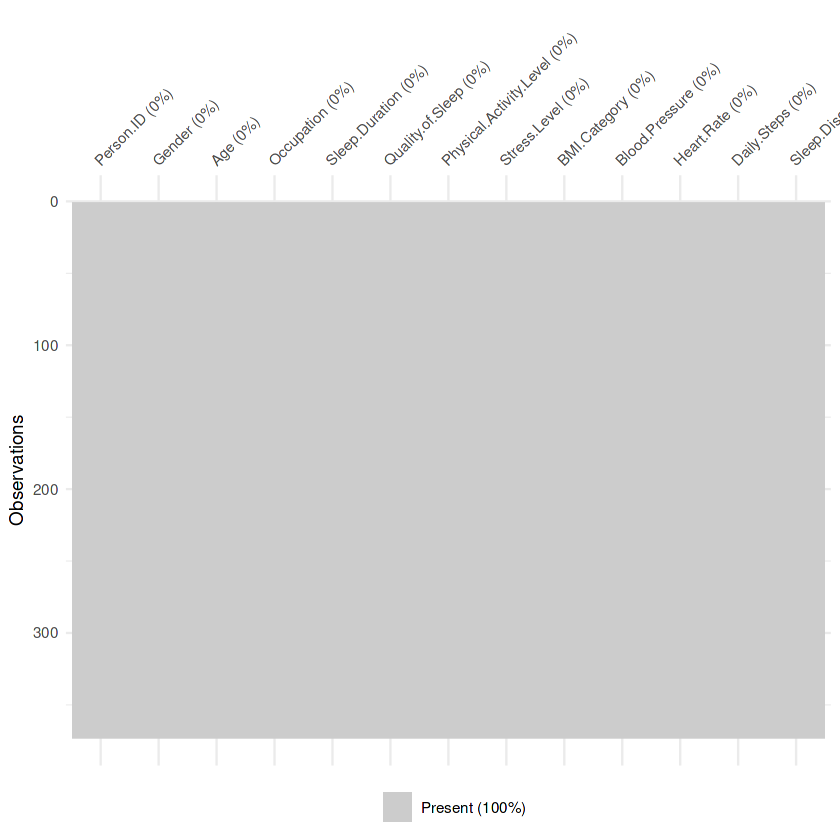

In [3]:
sleepdata %>% vis_miss()

We see that we do not have any missing data! We can now move forward with our analysis.

## Tidying Data

Now we will explore the basic characteristics of our data. We have 373 observations, and 13 variables. Our outcome variable, sleep duration, is measured in hours of sleep.

In [4]:
dim(sleepdata)
head(sleepdata)

[1] 373  13

,Person.ID,Gender,Age,Occupation,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,BMI.Category,Blood.Pressure,Heart.Rate,Daily.Steps,Sleep.Disorder
,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


Person ID is just an identifying variable, so we can remove it.

In [5]:
sleepdata <- select(sleepdata, -1)

We notice that some of the variable types are character types. This may be problematic for certain factors. Let's take a closer look at the variable blood pressure.

### Tidying blood pressure

Let's start by seeing how many unique values there are for blood pressure.

In [6]:
sleepdata$Blood.Pressure %>% unique()

[1] "126/83" "125/80" "140/90" "120/80" "132/87" "130/86" "117/76" "118/76"
 [9] "128/85" "131/86" "128/84" "115/75" "135/88" "129/84" "130/85" "115/78"
[17] "119/77" "121/79" "125/82" "135/90" "122/80" "142/92" "140/95" "139/91"
[25] "118/75"

Blood pressure is a character type with 25 unique values. This will not be very useful for our analysis, so let's fix this.

We will group the variable using data from the American Heart Association. 


First, we will separate the blood pressure readings into systolic and diastolic readings and make them numeric types. We can add these columns to our data temporarily. Then, we can create a new variable 'BP' which we will use as a nominal predictor. We will make any readings with both systolic and diastolic readings in the normal category 'Normal'. We can do the same for the other categories. Lastly, we will remove our systolic and diastolic columns from the data as well as the old blood pressure variable.

In [7]:
bp_split <- sleepdata$Blood.Pressure %>% str_split(pattern = '/', simplify = T)
systolic <- bp_split[,1] %>% as.numeric()
diastolic <- bp_split[,2] %>% as.numeric()
sleepdata <- sleepdata %>% add_column(systolic) %>% add_column(diastolic)

sleepdata <- sleepdata %>% mutate(BP = case_when((systolic < 120 & diastolic < 80) ~ 'Normal',
                     (systolic == 121 & diastolic == 79) ~ 'Elevated',
                     (systolic %in% range(130,139)) ~ 'High 1',
                    (diastolic %in% range(80,89)) ~ 'High 1', .default = 'High 1',
                    (systolic >=140 | diastolic >= 90) ~ 'Very High'),
                                  )
                      

We can see that our data now has separate diastolic and systolic readings, as well as a column 'BP' which holds the blood pressure category.

In [8]:
sleepdata %>% select(systolic, diastolic, Blood.Pressure, BP) %>% group_by(BP)


systolic,diastolic,Blood.Pressure,BP
<dbl>,<dbl>,<chr>,<chr>
126,83,126/83,High 1
125,80,125/80,High 1
125,80,125/80,High 1
140,90,140/90,Very High
140,90,140/90,Very High
140,90,140/90,Very High
140,90,140/90,Very High
120,80,120/80,High 1
120,80,120/80,High 1


We can remove the unnecessary columns and take a look at our updated data.

In [9]:
sleepdata <- select(sleepdata, -14, -13, -9)
head(sleepdata)

,Gender,Age,Occupation,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,BMI.Category,Heart.Rate,Daily.Steps,Sleep.Disorder,BP
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,High 1
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,High 1
3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,High 1
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Very High
5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Very High
6,Male,28,Software Engineer,5.9,4,30,8,Obese,85,3000,Insomnia,Very High


We will now make all of the character variables into factors. This will make our analysis easier later on.

In [10]:
sleepdata$BP <- sleepdata$BP %>% as.factor()
sleepdata$Gender <- sleepdata$Gender %>% as.factor()
sleepdata$Occupation <- sleepdata$Occupation %>% as.factor()
sleepdata$BMI.Category <- sleepdata$BMI.Category %>% as.factor()
sleepdata$Sleep.Disorder <- sleepdata$Sleep.Disorder %>% as.factor()

### Tidying BMI Categories

We also notice that in BMI category, we have both levels of 'Normal' and 'Normal Weight'. Let's merge these.


In [11]:
sleepdata$BMI.Category %>% unique()

[1] Overweight    Normal        Obese         Normal Weight
Levels: Normal Normal Weight Obese Overweight

In [12]:

levels(sleepdata$BMI.Category)[1] <- levels(sleepdata$BMI.Category)[2]
levels(sleepdata$BMI.Category)

[1] "Normal Weight" "Obese"         "Overweight"

Now our data has been cleaned and we can continue exploring.

Let's take a look at the distribution of our outcome variable, sleep duration.

## Histogram of Sleep Distribution



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.800   6.400   7.200   7.129   7.800   8.500 

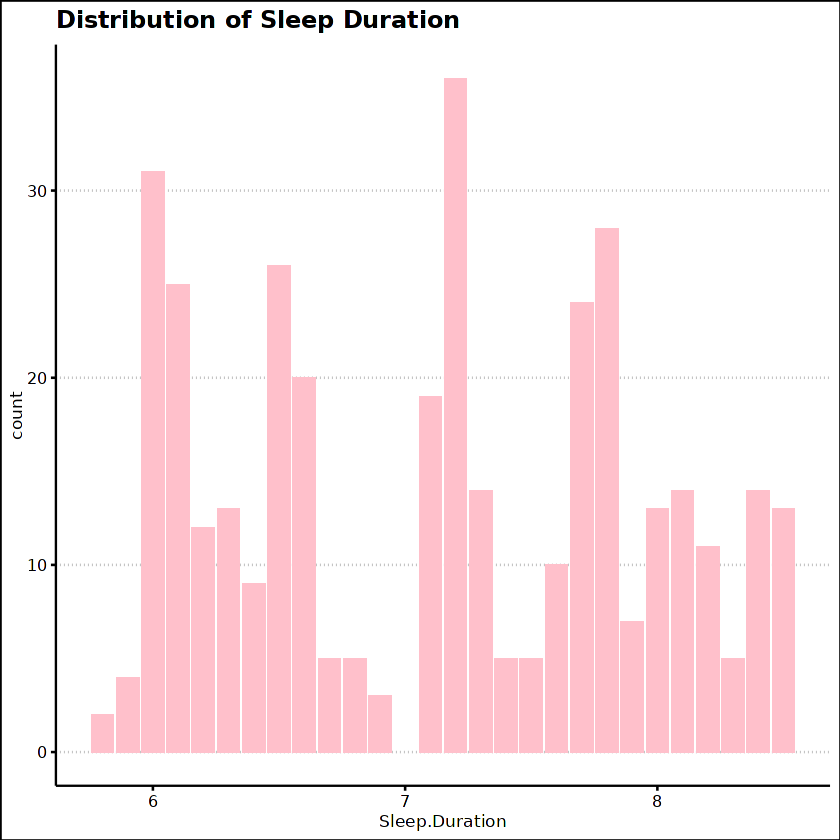

In [13]:

ggplot(sleepdata, aes(Sleep.Duration)) +
  geom_bar(fill='pink' ) + theme_clean() +
  labs(
    title = "Distribution of Sleep Duration"
  )
summary(sleepdata$Sleep.Duration)

The respondents' sleep duration ranged from 5.8 to 8.5 hours of sleep, with a mean of 7.129 hours. It appears to be somewhat normally distributed.

## Looking at Predictors

### Correlation Plot

In order to get a better idea of the relationships between our quantitative predictors, we can make a correlation plot.

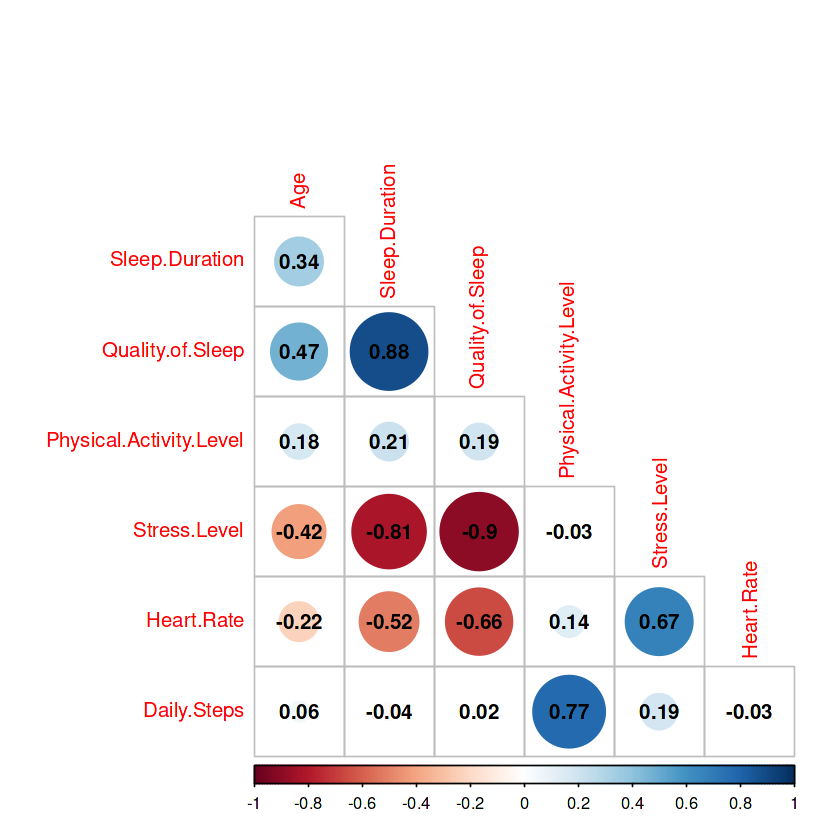

In [14]:
sleepdata %>%
  select(where(is.numeric)) %>% 
  cor(use = "pairwise.complete.obs") %>% 
  corrplot(method = 'circle', type = 'lower', addCoef.col = 1, diag = F)



We can see that sleep duration is most highly correlated with quality of sleep and stress level. Those who slept longer also tended to have higher quality of sleep and were less stressed. We also see a marginal correlation with between lower heart rate and longer sleep. These relationships line up quite well with our intuitive understanding of what is connected to sleep.

Surprisingly we do not see a strong correlation with either physical activity level or daily steps.

We also see that stress level and quality of sleep and strongly correlated. If we were modeling for inference, we would need to address this to avoid multicollinearity, but since we are modeling for prediction I would rather leave them in the model since they are both important predictors.

### Sleep Quality

Let's explore the relationship between sleep quality and sleep duration with a scatterplot.


`geom_smooth()` using formula = 'y ~ x'


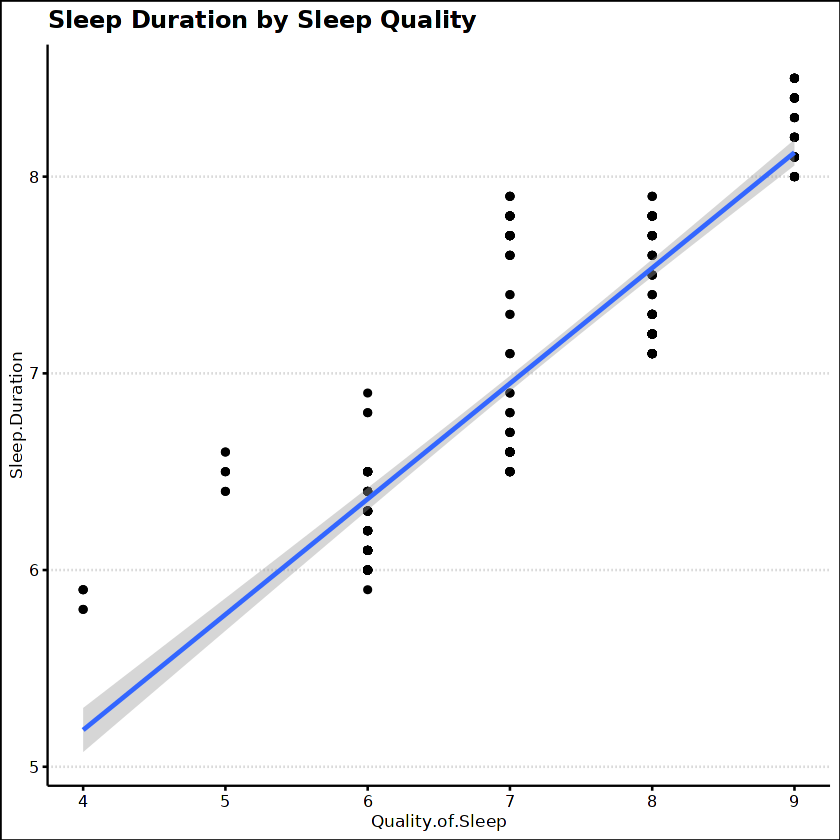

In [15]:
ggplot(data = sleepdata, aes(Quality.of.Sleep, Sleep.Duration)) + geom_point() + geom_smooth(method = lm) + theme_clean() + labs(title = 'Sleep Duration by Sleep Quality')

Here we can visualize the correlation between sleep quality and duration. Sleep quality is a subjective ranking from 1-10, so it makes sense that people who slept for a longer duration would generally also rate their quality of sleep higher.

Stress Level

Now let's look at stress level. We could do this with a scatterplot also, but since stress level is also on an interval scale a bar graph is appropriate.

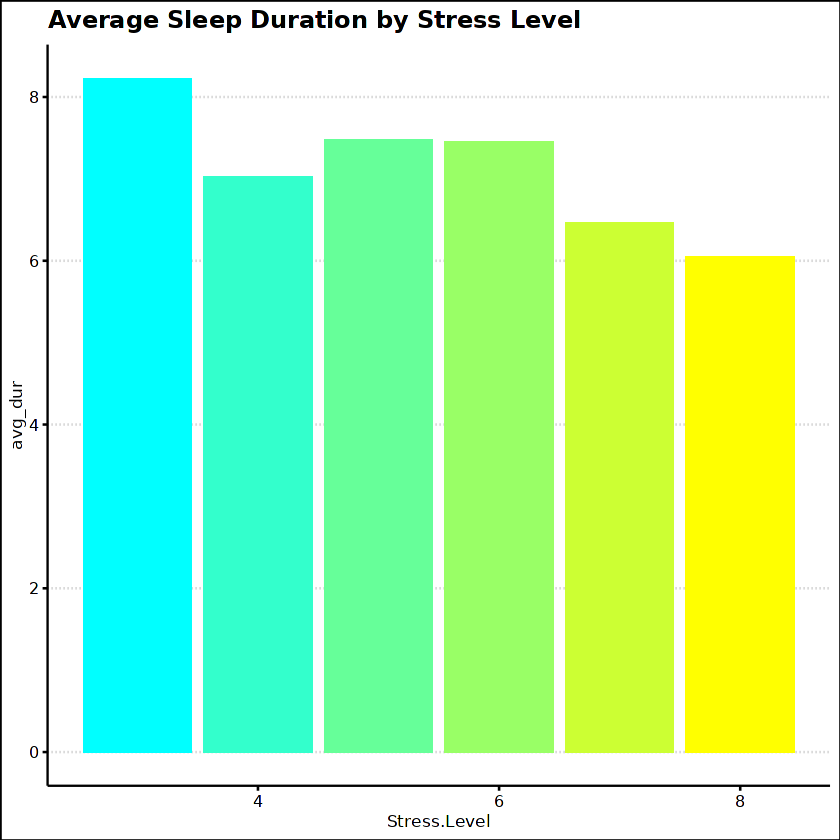

In [16]:
sleepdata %>% group_by(Stress.Level) %>% 
  summarise(avg_dur = mean(Sleep.Duration)) %>% 
  ggplot() + geom_col(aes(y = avg_dur, x = Stress.Level), fill = colorRamps::cyan2yellow(6)) + theme_clean() + labs(title = 'Average Sleep Duration by Stress Level')

People with the lowest stress levels slept for the longest, while people with the highest stress levels had the shortest length of sleep.

Age

Now lets take a look at Age. Instead of using a straight line, let's take a more flexible view of the relationship.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


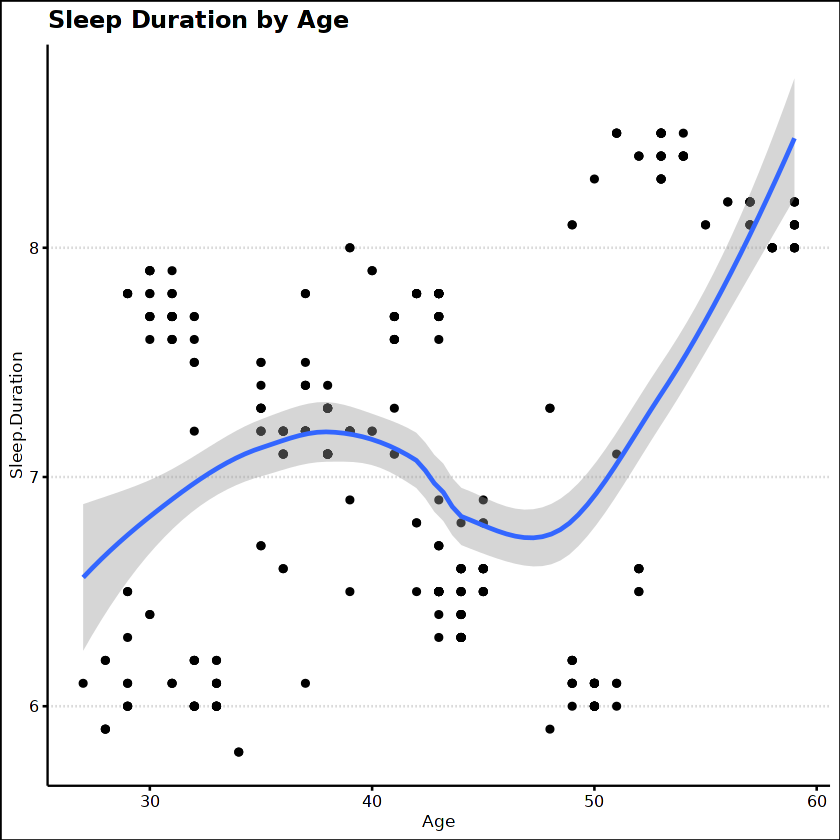

In [17]:
ggplot(sleepdata, aes(x = Age, y = Sleep.Duration)) + geom_point() + geom_smooth() + theme_clean() + 
  labs(title = 'Sleep Duration by Age')

It looks like sleep duration is linearly related to age after around age 48, but before that it is a bit more complicated. It would have been interesting to see how duration changed for teenagers and younger adults, but our data only ranges from ages 27 - 59.

Anova for Categorical Predictors

We saw a correlation plot earlier for all of our numeric predictors, but the nominal predictors were not included. One question we might ask ourselves is which of our categorical variables are the most important?

We could try to answer this with an anova to see if the average sleep duration differs between levels of each predictor. The results of this test may not be completely accurate, but it will give us an idea of which predictors are the most significant.

In [18]:
  aov(data = sleepdata, formula = Sleep.Duration ~ Gender + Occupation + BMI.Category + BP) %>% summary()

              Df Sum Sq Mean Sq F value  Pr(>F)    
Gender         1   3.31   3.313   8.793 0.00323 ** 
Occupation    10  93.19   9.319  24.737 < 2e-16 ***
BMI.Category   2   3.18   1.592   4.226 0.01534 *  
BP             3   1.39   0.464   1.231 0.29840    
Residuals    356 134.12   0.377                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

It looks like sleep duration differs the most significantly occupation, followed by gender and then BMI category. It appears that duration did not differ as drastically across blood pressure categories.

Occupation

Let's visualize the difference in sleep duration between occupations. Some of the occupations are only observed a few times, so let's only visualize those that appear more than 5 times.

Occupation,n
<fct>,<int>
Accountant,37
Doctor,71
Engineer,63
Lawyer,47
Manager,1
Nurse,72
Sales Representative,2
Salesperson,32
Scientist,4


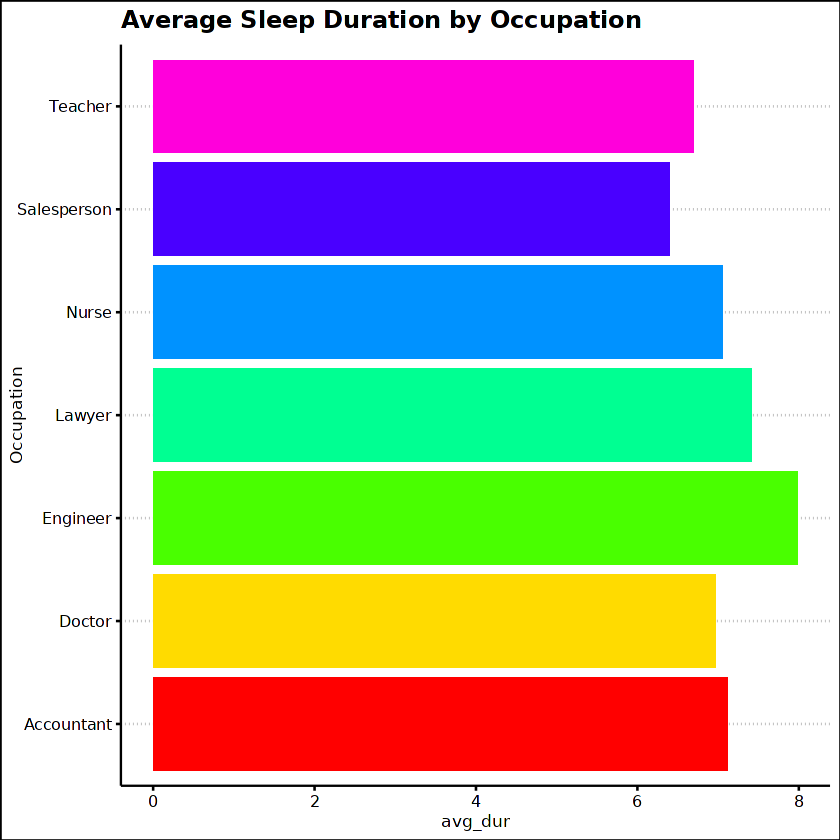

In [19]:
sleepdata %>% group_by(Occupation) %>% count()



sleepdata %>% group_by(Occupation) %>% filter(! Occupation %in% c('Manager','Sales Representative', 'Scientist','Software Engineer')) %>% 
  summarise(avg_dur = mean(Sleep.Duration)) %>% 
  ggplot() + geom_col(aes(x = avg_dur, y = Occupation), fill = rainbow(7)) + theme_clean() + labs(title = 'Average Sleep Duration by Occupation')

Engineers get the most sleep of all the professions, followed by lawyers and accountants.

### Blood Pressure

We saw earlier that Blood Pressure will likely not have a large difference. Let's visualize Blood Pressure and BMI category.

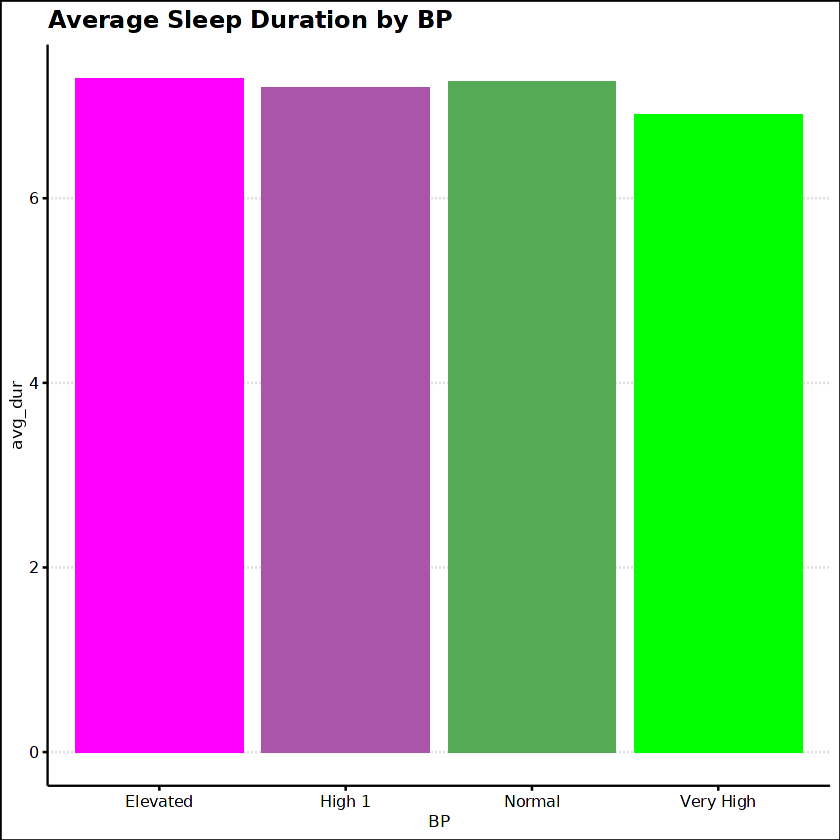

In [20]:
sleepdata %>% group_by(BP) %>% 
  summarise(avg_dur = mean(Sleep.Duration)) %>% 
  ggplot() + geom_col(aes(x = BP,y  = avg_dur), fill = colorRamps::magenta2green(4)) + theme_clean() + labs(title = 'Average Sleep Duration by BP')

As expected, there doesn't seem to be a huge difference between blood pressure groups, although people with very high blood pressure appear to get less sleep.

### BMI

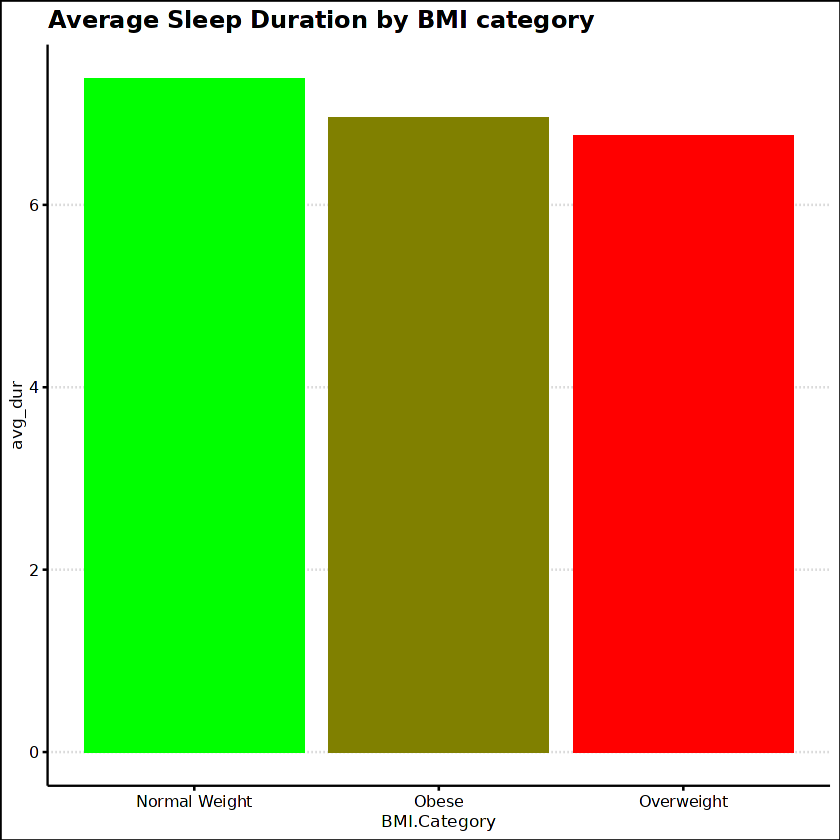

In [21]:
sleepdata %>% group_by(BMI.Category) %>% 
  summarise(avg_dur = mean(Sleep.Duration)) %>% 
  ggplot() + geom_col(aes(x = BMI.Category,y  = avg_dur), fill = colorRamps::green2red(3)) + theme_clean() + labs(title = 'Average Sleep Duration by BMI category')



For BMI category, we can see that sleep duration appears to decrease as weight category increases.

# Model Fitting

Now that we have a better understanding of the data, we can begin to build our model. We will be testing 5 different types of models on our data: Linear Regression, K-nearest Neighbors, Elastic Net, Pruned Decision Tree, and Random Forest. We will split the data into training and testing sets, make a recipe, and use k- fold cross validation to tune our hyper-parameters before we choose our best model and test it using our testing data.

## Splitting our Data

The first thing we must do is randomly split our data into a training and testing set. For the initial split, we will use 75% of our data for training and 25% for testing. We will use stratified sampling for our sleep duration variable on both our original split and our folds to ensure that we get an even distribution of duration outcomes in all of our minisets.

We will use k-fold cross validation with k = 5 to tune our parameters and compare our models. This means that our training data will be split into 5 folds and it will be tested on each fold individually after being fitted to the other 4. This will give us an accurate prediction for test error while still being able to fit with all of our training data.

We will also set a seed so that we can recreate our results.

In [22]:
set.seed(2302)

sleep_split <- initial_split(sleepdata, prop = 3/4, strata = Sleep.Duration)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)
sleep_folds <- vfold_cv(sleep_train, v = 5, strata = Sleep.Duration)


## Making Recipe

Now, we can make our recipe using all of our predictors. We will dummy code all of our nominal predictors and center and scale all of our numeric predictors. We will also prep and bake the recipe to make sure that there are not any errors.

In [23]:
sleeprecipe <- recipe(data = sleep_train, Sleep.Duration ~ .) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors())

sleeprecipe
prep(sleeprecipe) %>% bake(sleep_train)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 



Number of variables by role



outcome:    1
predictor: 11



── Operations 



• Centering and scaling for: all_numeric_predictors()



• Dummy variables from: all_nominal_predictors()



Age,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Heart.Rate,Daily.Steps,Sleep.Duration,Gender_Male,Occupation_Doctor,Occupation_Engineer,⋯,Occupation_Scientist,Occupation_Software.Engineer,Occupation_Teacher,BMI.Category_Obese,BMI.Category_Overweight,Sleep.Disorder_None,Sleep.Disorder_Sleep.Apnea,BP_High.1,BP_Normal,BP_Very.High
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.702724,-1.070094,-0.75894457,0.3384419,1.71839980,-1.5962826,6.1,1,0,0,⋯,0,1,0,0,1,1,0,1,0,0
-1.588165,-1.070094,0.09602135,1.4652304,1.22026096,2.0769672,6.2,1,1,0,⋯,0,0,0,0,0,1,0,1,0,0
-1.588165,-2.727399,-1.32892185,1.4652304,3.71095514,-2.3562654,5.9,1,0,0,⋯,0,0,0,1,0,0,1,0,0,1
-1.588165,-2.727399,-1.32892185,1.4652304,3.71095514,-2.3562654,5.9,1,0,0,⋯,0,1,0,1,0,0,0,0,0,1
-1.473606,-1.070094,-0.85394078,0.9018361,2.96374689,-2.0396059,6.3,1,0,0,⋯,0,0,1,1,0,0,0,0,0,1
-1.473606,-1.070094,-1.32892185,1.4652304,-0.02508613,0.8103293,6.1,1,1,0,⋯,0,0,0,0,0,1,0,1,0,0
-1.473606,-1.070094,-1.32892185,1.4652304,-0.02508613,0.8103293,6.1,1,1,0,⋯,0,0,0,0,0,1,0,1,0,0
-1.473606,-1.070094,-1.32892185,1.4652304,-0.02508613,0.8103293,6.0,1,1,0,⋯,0,0,0,0,0,1,0,1,0,0
-1.473606,-1.070094,-1.32892185,1.4652304,-0.02508613,0.8103293,6.0,1,1,0,⋯,0,0,0,0,0,1,0,1,0,0


## Setting Up models

Our next task is setting up our 5 models. We will use a standard linear regression model to begin with. For the rest of our models, we will tune certain parameters, meaning we will try out different values of them to pick the best one.

For our k-nearest neighbors model, we will be tuning the number of neighbors. Our elastic net model will be tuned for mixture and penalty. We will tune cost complexity for the pruned tree model. For our random forest, we will tune mtry( The number of predictors that will be randomly sampled at each split), number of trees, and min_n (The minimum number of data point required for another split to occur).

In [24]:
#linear regression model
lr_mod <- linear_reg() %>% set_mode("regression") %>% set_engine("lm")

#knn model
knn_mod <- nearest_neighbor(neighbors = tune()) %>%
  set_mode("regression") %>%
  set_engine("kknn")

#elastic net model
en_mod <- linear_reg(mixture = tune(), penalty = tune()) %>% 
  set_engine('glmnet') %>% 
  set_mode('regression')

#pruned tree model
tree_spec <- decision_tree(cost_complexity = tune()) %>%
  set_engine("rpart") %>% 
  set_mode("regression")



#random forest
rf_reg_spec <- rand_forest(mtry = tune(), 
                           trees = tune(), 
                           min_n = tune()) %>%
  set_engine("ranger", importance = "impurity") %>% 
  set_mode("regression")



## Making workflows

For each of our models, we need to make a workflow, add the appropriate model, and add our recipe.

In [25]:
# linear regression
lm_wkflow <- workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(sleeprecipe)

# k nearest neighbors
knn_wkflow <- workflow() %>% 
  add_model(knn_mod) %>% 
  add_recipe(sleeprecipe)

# elastic net
en_wkflow <- workflow() %>% 
  add_model(en_mod) %>% 
  add_recipe(sleeprecipe)

# pruned decision tree
tree_wf <- workflow() %>% 
  add_model(tree_spec) %>% 
  add_recipe(sleeprecipe)

# random forest
rf_reg_wf <- workflow() %>% 
   add_model(rf_reg_spec) %>% 
   add_recipe(sleeprecipe)


## Making Grids

In order to tune our parameters, we will make grids of all of the values we want to try for each parameter. For simplicity, I will choose 5 levels for each, meaning each parameter will be tested with 5 different values in its specified range.

In [26]:

grid_knn <- grid_regular(neighbors(range = c(1, 10)), levels = 5)

grid_en <- grid_regular(penalty(), mixture(range = c(0,1)), levels = 5)

param_grid <- grid_regular(cost_complexity(range = c(-3, -1)), levels = 5)

grid_rf<- grid_regular(mtry(range = c(1, 6)), 
                        trees(range = c(200, 600)),
                        min_n(range = c(10, 20)),
                        levels = 5)



## Tuning Models

Using the grids we just made, we can now tune our parameters on our 5 folds. Each level of each parameter will be tested on each fold, which means we are currently generating hundreds of models.

I will also fit our linear model to the folds in this step so it can be used later.

In [27]:
#no tuning for lm
lm_fit <- fit_resamples(lm_wkflow, resamples = sleep_folds)

#tuning knn
tune_knn <- tune_grid(
  object = knn_wkflow, 
  resamples = sleep_folds, 
  grid = grid_knn
)
 
#tuning elastic net
tune_en <- tune_grid(object = en_wkflow,
                      resamples = sleep_folds,
                      grid = grid_en)
 


#tuning pruned tree
tune_tree <- tune_grid(
  tree_wf, 
  resamples = sleep_folds, 
  grid = param_grid
)

#tuning random forest
tune_rf <- tune_grid(
  rf_reg_wf, 
  resamples = sleep_folds, 
  grid = grid_rf
)

→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")



There were issues with some computations   A: x1



There were issues with some computations   A: x2



→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.



There were issues with some computations   A: x1



There were issues with some computations   A: x4



There were issues with some computations   A: x5




## Comparing Models

Let's visualize some of our parameters:

For each model, I will also display the chosen values of the parameters, which was chosen by minimizing RMSE.

### KNN

For our knn model, we tuned number of neighbors.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,0.1651744,5,0.01874481,Preprocessor1_Model4


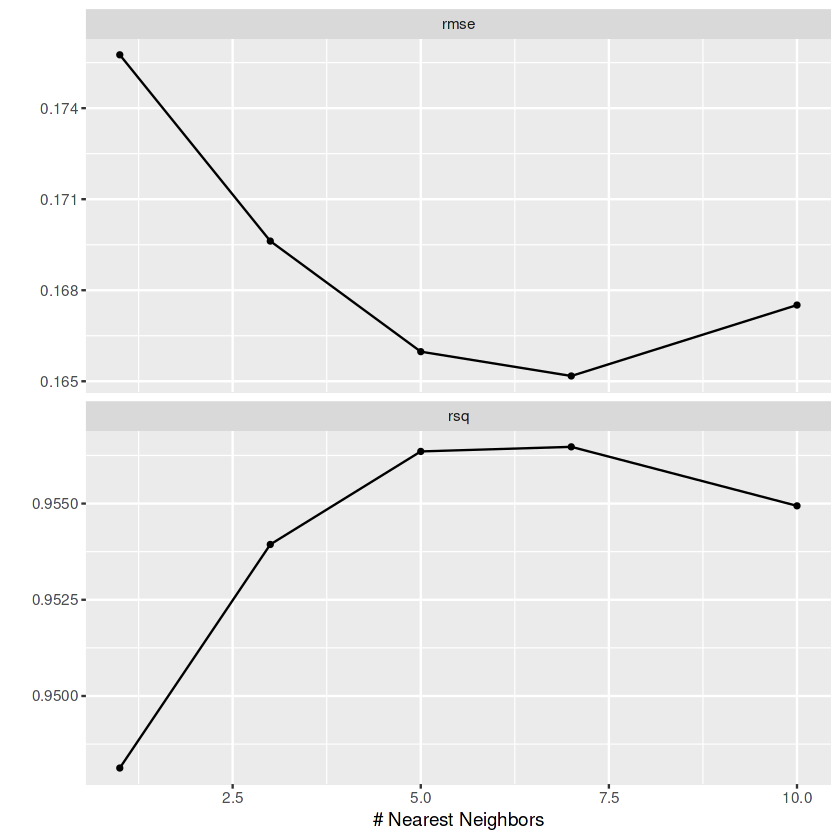

In [28]:
autoplot(tune_knn)
best_knn <- show_best(tune_knn, metric = 'rmse')[1,]
best_knn


As we can see, it looks like we have both the lowest root mean squared error and $R^2$ at 7 neighbors, meaning we will most likely get the lowest amount of test error if we use k = 7.

### Elastic Net

penalty,mixture,.metric,.estimator,mean,n,std_err,.config
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1e-10,0,rmse,standard,0.247256,5,0.01139811,Preprocessor1_Model01


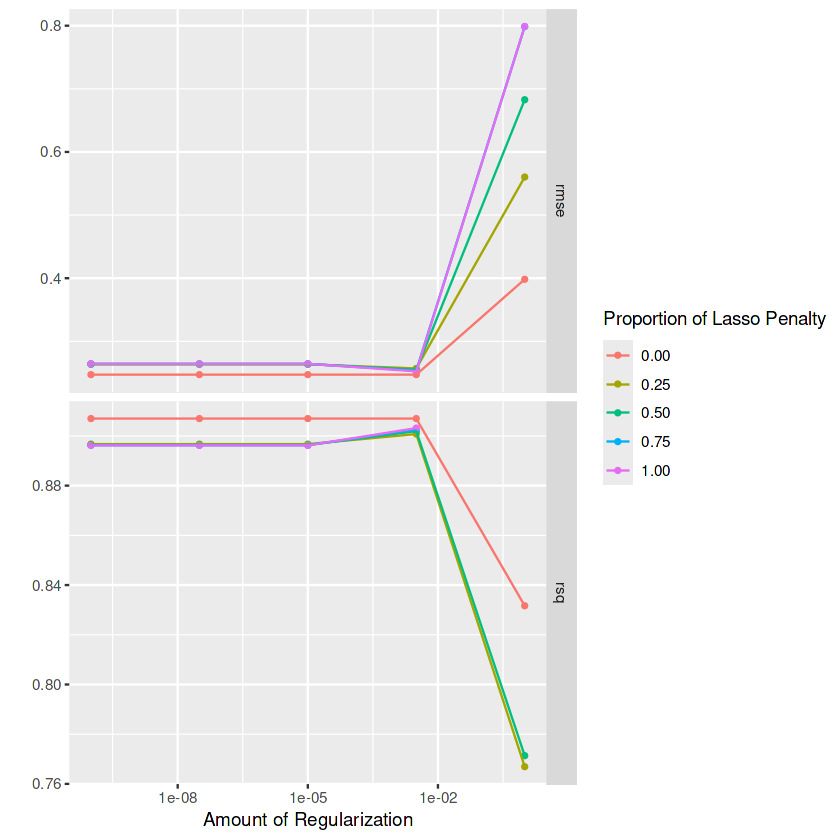

In [29]:
autoplot(tune_en)

best_en <- show_best(tune_en, metric = 'rmse')[1,]
best_en


For our elastic net, we tuned penalty and mixture. The red line indicates that the proportion of lasso penalty should be zero. We also see that for all proportions, error increases quickly when regularization is more than about .001, and the lowest value is probably best.

### Pruned Decision Tree


cost_complexity,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
0.001,rmse,standard,0.124771,5,0.01485514,Preprocessor1_Model1


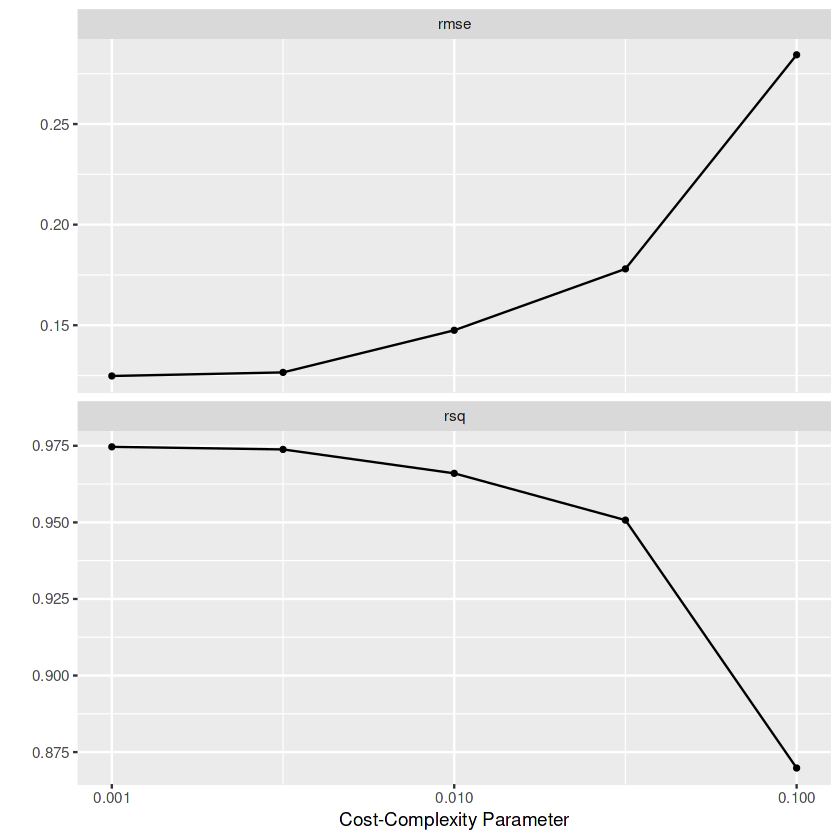

In [30]:
autoplot(tune_tree)

best_tree <- show_best(tune_tree, metric = 'rmse')[1,]
best_tree

For our pruned decision tree, we tuned cost-complexity. From our graph, error looks to be the lowest at .001.

### Random Forest


mtry,trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,300,10,rmse,standard,0.1006825,5,0.01500629,Preprocessor1_Model010


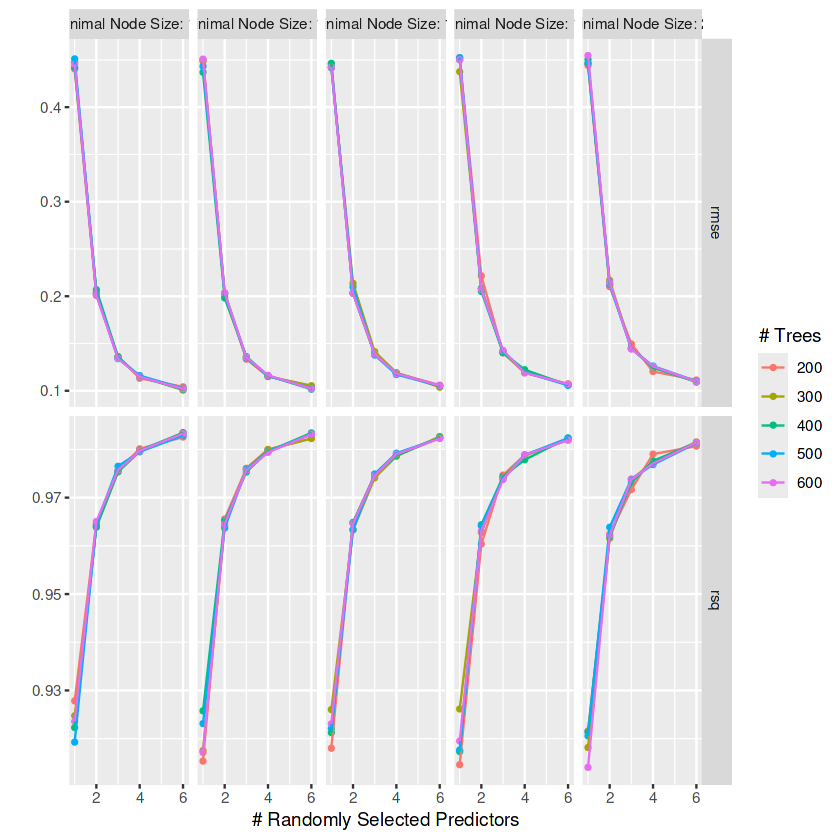

In [31]:
autoplot(tune_rf)


best_rf <- show_best(tune_rf, metric = 'rmse')[1,]
best_rf


For the random forest model, we tuned the number of predictors that will be randomly sampled at each split, number of trees, and the minimum number of data point required for another split to occur. Let's begin by looking at number of trees. From the graph, we do not see an obvious difference in error between the number of trees. For the number of selected predictors, 6 clearly appears to perform the best. For the minimum n parameter, the values tested were 10, 12, 15, 17, and 20. As with the number of trees, it is tough to distinguish from the graph, but it looks as though n = 10 might be slightly better than the rest.

We also need to obtain the average RMSE of our linear model.


In [32]:
lm_rmse <- show_best(lm_fit)[3]

Warning message in show_best(lm_fit):
“No value of `metric` was given; "rmse" will be used.”


## Finalizing workflows

We can now specify our tuned parameters in our workflows for each model.

In [33]:
fin_knn_wf <- finalize_workflow(knn_wkflow, best_knn)


fin_en_wf <- finalize_workflow(en_wkflow, best_en)


fin_tree_wf <- finalize_workflow(tree_wf, best_tree)


fin_rf_wf <- finalize_workflow(rf_reg_wf, best_rf)


## Choosing the best model

After finding the best version of each model, and we are now ready to compare our model types!

We can do this by comparing the average RMSE across folds of each of our best models in a table.

In [34]:
rmse_table <- tibble(Model = c('Linear Regression', 'KNN', 'Elastic Net', 'Pruned Tree', 'Random Forest'), RMSE = c(as.numeric(lm_rmse), as.numeric(best_knn[4]), as.numeric(best_en[5]), as.numeric(best_tree[4]), as.numeric(best_rf[6])))
rmse_table


Model,RMSE
<chr>,<dbl>
Linear Regression,0.2661078
KNN,0.1651744
Elastic Net,0.2472560
Pruned Tree,0.1247710
Random Forest,0.1006825


We can visualize these results:

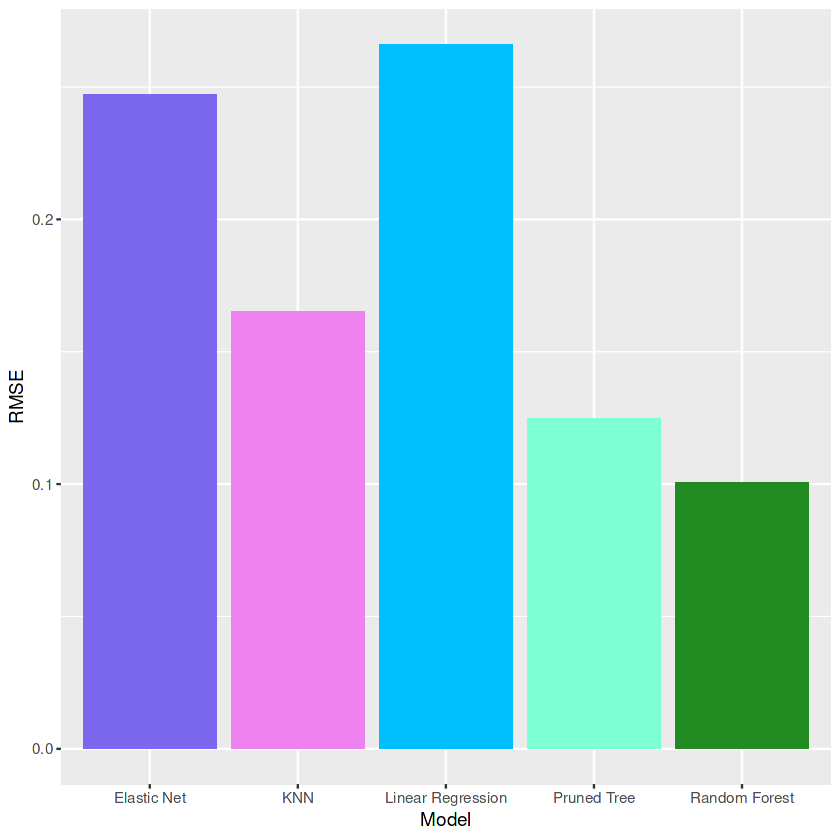

In [35]:
ggplot(rmse_table, aes(x = Model, y = RMSE)) + geom_col(fill = c('deepskyblue','violet', 'mediumslateblue','aquamarine','forestgreen'))


Our Random Forest Model performed the best! In fact, both tree models outperformed the rest and the classic linear regression model did the worst of all of our models.

## Fitting to testing set

We are finally ready to fit our final random forest model to our testing data.

In [36]:
fin_rf_fit <- fit(object = fin_rf_wf, data = sleep_train)
mymetrics <- metric_set(rsq, rmse)

augment(fin_rf_fit, new_data = sleep_test) %>%
  mymetrics(truth = Sleep.Duration, estimate = .pred)




.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.9795288
rmse,standard,0.1140393


Our model had a testing error of 0.1109141 with an $R^2$ of 0.98049! Although this is not quite as good as our training error (Recall that the error across folds was 0.102041), we still have created a very accurate predictive model of Sleep Duration.

We can also look at how our second best model performed.

In [37]:
fin_tree_fit <- fit(object = fin_tree_wf, data = sleep_train)


augment(fin_tree_fit, new_data = sleep_test) %>%
  mymetrics(truth = Sleep.Duration, estimate = .pred)



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.9760542
rmse,standard,0.1230960


Our single tree model is almost as good as our random forest with a RMSE of 0.12309 and and $R^2$ of 0.976054.

### Visualizing Results

For fun, we can look at our pruned tree model with a plot of our tree.

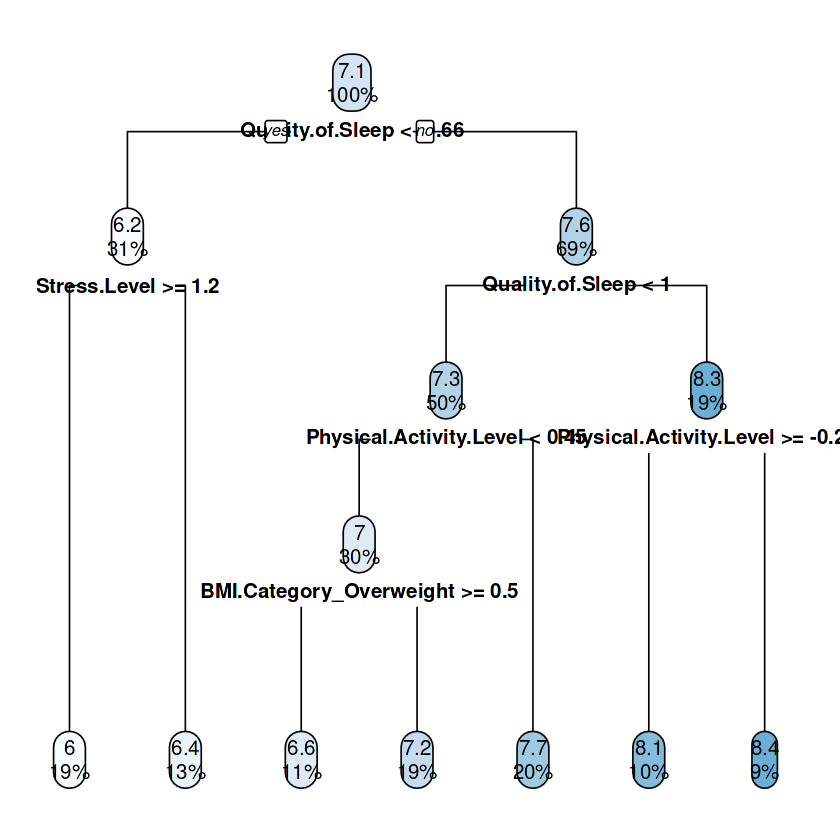

In [38]:
fin_tree_fit %>%
  extract_fit_engine() %>%
  rpart.plot(roundint=FALSE)

The first binary split was made on the sleep quality predictor, which makes sense since we saw that it was highly correlated with our outcome variable. If quality of sleep was in the lower part of the split, it directly predicted sleep duration with stress level. If the value was in the upper part, it would be split on sleep quality again before being split on physical activity level. This is surprising since we saw that physical activity was not strongly correlated with duration in general.

To showcase the accuracy of our model, we can graph the actual sleep duration values from the testing set with the predicted values from our final random forest model.


New names:
• `` -> `...2`


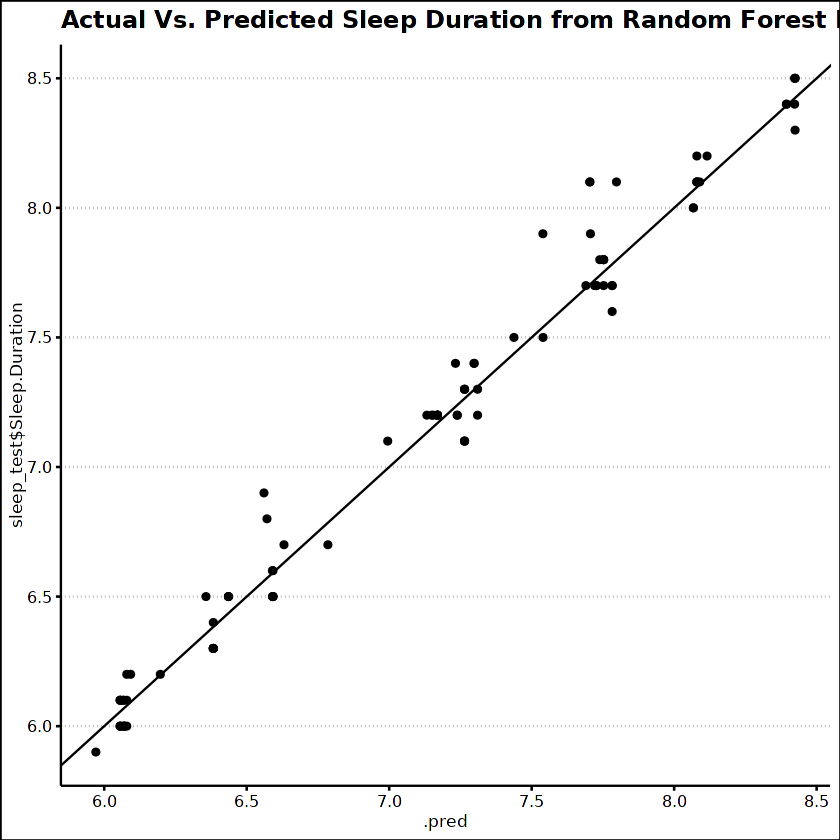

In [39]:
predictions <- predict(fin_rf_fit, new_data = sleep_test)

comparison_table <- bind_cols(predictions, sleep_test$Sleep.Duration)

comparison_table %>% ggplot() + geom_point(aes(x = .pred, y = sleep_test$Sleep.Duration)) + geom_abline() + 
  labs(title = 'Actual Vs. Predicted Sleep Duration from Random Forest Model') + theme_clean()


We can also see which variables were most important in the model

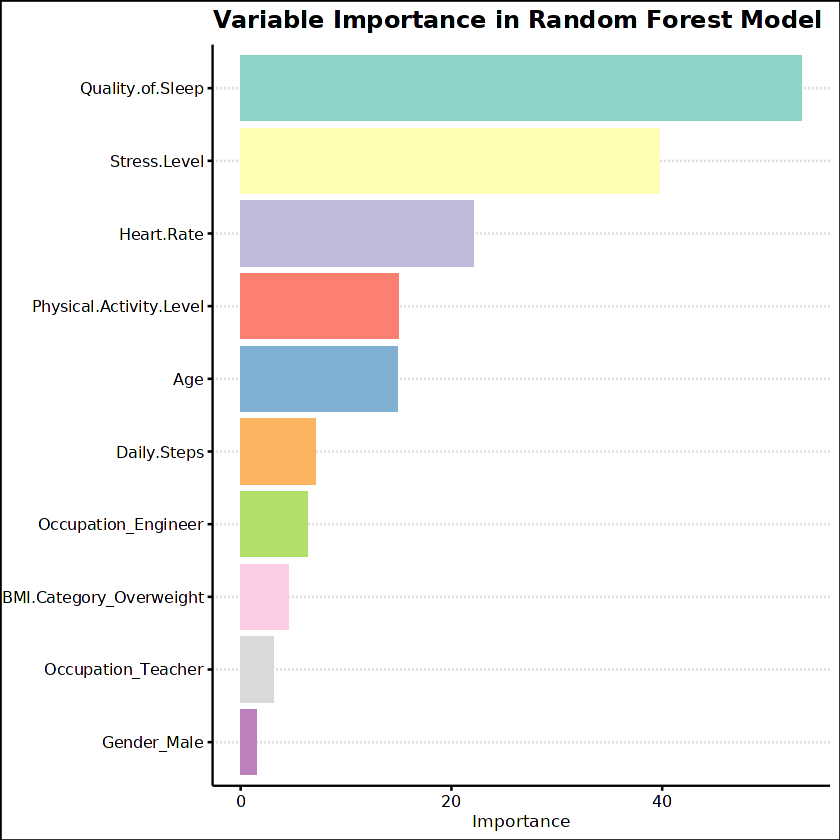

In [40]:
fin_rf_fit %>% extract_fit_parsnip() %>% 
  vip(aesthetics = list(fill = brewer.pal(name = 'Set3',n = 10))) + theme_clean() + labs(title = 'Variable Importance in Random Forest Model')

As we may have expected from our correlation plot, quality of sleep and stress level were the most important predictors. One thing that is surprising here is that daily steps was somewhat important in the model even though it was essentially uncorrelated with duration (r = -0.04). Also, although the engineer occupation being important makes sense from our graph, it is surprising that the teacher occupation ranked even though it did not have the highest or lowest average.

# Conclusion

After tuning and fitting five different models, we can conclude that a Random Forest is the best fit for our model. The model performed very well on the testing data with a RMSE of 0.1109141 and an $R^2$ of 0.98049. This means that about 98% of the variance in our outcome variable sleep duration is explained by our model. One benefit of the random forest is that its structure is extremely flexible and does not make any assumptions before fitting the model. Since we are focused on prediction in this project, the success of this model is to be expected considering that nonlinear models such as tree-based models have much higher predictive power compared to other methods. If we were interested in inference, it is likely that we would prefer a parametric model such as linear regression.

Our second place model, the pruned decision tree, also performed quite well. We see that even with the simplicity of this model, it explains over 97% of the variation in sleep duration in our testing data. This was surprising to me considering that single tree models are known to be less accurate in their predictions and are notorious for overfitting. For our model, this was not the case. In fact, we actually saw slightly lower testing error (0.12309) compared to RMSE across folds (0.124771). I think one reason the tree models may have performed so well is that many of our predictors have a relatively small range, so the groups made during binary splitting are more compact.

Our worst performing model was the classic linear regression model. Our data rejected the rigidity of the parametric model, implying that the relationships within our data are more complex than would be appropriate for a linear model. However, one thing to note is that I did not include any interactions in the recipe. If we were to further explore this data searching for interaction effects, it is possible that the linear model would perform better. Also notice that our elastic net model performed better than our classic linear model. Recall that we had a strong correlation between our quality of sleep and stress level predictors. One benefit of regularization is that it can better handle instances of multicollinearity, which may partially explain its superior performance here.

After exploring this data, I wonder if perhaps the project would be more powerful if we were to combine sleep quality and duration as an outcome rather than only using duration. Both are important facets of sleep health, and it would be interesting to see if we could retain the predictive accuracy of the model without using any actual sleep metrics as predictors. Furthermore, analyzing this data with a focus on inference would be another fruitful avenue for learning more about which health factors are related to sleep.

Overall, through exploring, analyzing, and modeling our data we have managed to create a powerful machine learning model for predicting sleep as well as better understand the complex relationships surrounding sleep and health. Hopefully, these results will prompt us to be more mindful of all the ways in which our health is interconnected.

With this project being one of my first experiences with machine learning, I can honestly say that I am grateful for the experience and I am excited to be able to conduct more machine learning analyses in the future!

## Sources

Shan, Henry. “Sleep, Health, and Lifestyle.” *Kaggle*, 30 Jan. 2024, *www.kaggle.com/datasets/henryshan/sleep-health-and-lifestyle/data*.

“Understanding Blood Pressure Readings.” *Www.Heart.Org*, American Heart Association, 8 Aug. 2024, *www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings*.

Watson, Nathaniel F, et al. “Recommended Amount of Sleep for a Healthy Adult: A Joint Consensus Statement of the American Academy of Sleep Medicine and Sleep Research Society.” *Sleep*, U.S. National Library of Medicine, 1 June 2015, *www.ncbi.nlm.nih.gov/pmc/articles/PMC4434546/*.